# SeSS (Semantic similarity score)

In [2]:
!pip install transformers sentence-transformers networkx matplotlib torch tf-keras -q

import torch
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForConditionalGeneration
from sentence_transformers import SentenceTransformer
import numpy as np
from PIL import Image
import requests

##Load ur images to comapre

In [3]:
urls = [
    "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg",  #woman with dog image
    "https://images.unsplash.com/photo-1507525428034-b723cf961d3e"                #beach image
]
images = [Image.open(requests.get(u, stream=True).raw).convert("RGB") for u in urls]

## Generate captions for our images

In [4]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

captions = []
for i, image in enumerate(images):
    inputs = processor(image, return_tensors="pt")
    out = model.generate(**inputs, max_new_tokens=20)
    caption = processor.decode(out[0], skip_special_tokens=True)
    captions.append(caption)
    print(f"🖼️ Image {i+1} Caption → {caption}")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


🖼️ Image 1 Caption → a woman sitting on the beach with her dog
🖼️ Image 2 Caption → a beach with a sunset and a sandy shore


## use comman NLP to parse sentences and generate Scene Graphs

In [6]:
!pip install spacy==3.7.0 -q
!python -m spacy download en_core_web_sm -q
import spacy
nlp = spacy.load("en_core_web_sm")

def robust_scene_parse(caption):
    doc = nlp(caption)
    triples = []
    for tok in doc:
        # verb-based
        if tok.pos_ == "VERB":
            subs = [w.text for w in tok.lefts if w.dep_ in ("nsubj","nsubjpass")]
            objs = [w.text for w in tok.rights if w.dep_ in ("dobj","pobj","attr","obl")]
            for s in subs:
                for o in objs:
                    if s != o:
                        triples.append((s, tok.lemma_, o))
        # prepositions
        if tok.dep_ == "pobj" and tok.head.pos_ == "ADP":
            obj = tok.text
            prep = tok.head.text
            head = tok.head.head
            subj = head.text
            if head.pos_ == "VERB":
                subs = [w.text for w in head.lefts if w.dep_ in ("nsubj","nsubjpass")]
                subj = subs[0] if subs else head.text
            if head.dep_ == "acl" and head.head.pos_ == "NOUN":
                subj = head.head.text
            if subj and subj != obj:
                triples.append((subj, prep, obj))
        # adjectival clause (woman sitting)
        if tok.dep_ == "acl" and tok.pos_ == "VERB":
            subj = tok.head.text
            objs = [w.text for w in tok.rights if w.dep_ in ("pobj","dobj")]
            for o in objs:
                triples.append((subj, tok.lemma_, o))

    clean = {(s.strip(), r.strip(), o.strip()) for s,r,o in triples if s.strip() and r.strip() and o.strip()}
    return {"relations": [{"subject": {"name": s}, "relation": r, "object": {"name": o}} for s,r,o in clean]}

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
  You can safely remove it manually.
C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Move our graphs to networkX to visualize

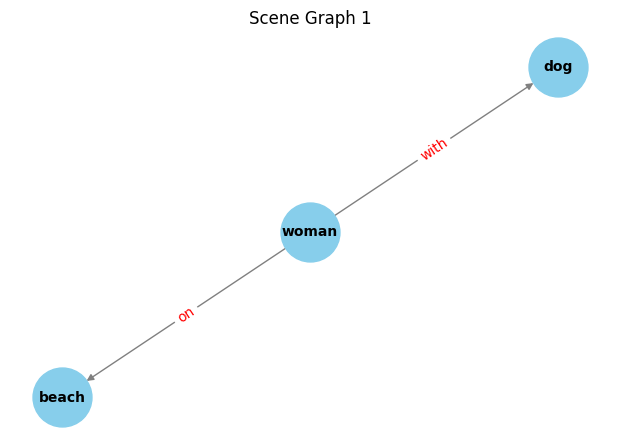

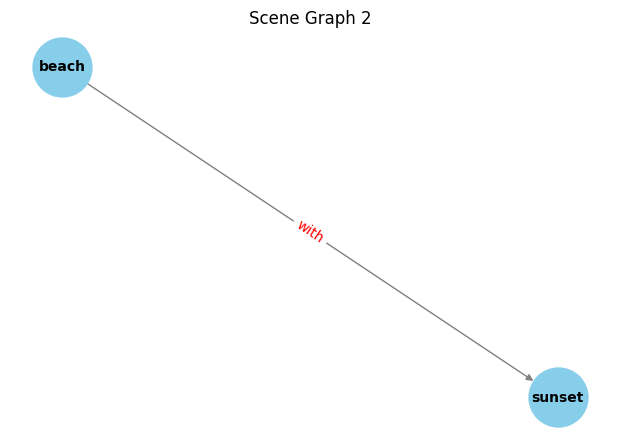

In [7]:
def scenegraph_to_networkx(graph_data):
    G = nx.DiGraph()
    for rel in graph_data["relations"]:
        s = rel["subject"]["name"]
        r = rel["relation"]
        o = rel["object"]["name"]
        G.add_node(s)
        G.add_node(o)
        G.add_edge(s, o, label=r)
    return G

def visualize_graph(G, title="Scene Graph"):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6,4))
    nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=1800,
            edge_color="gray", font_size=10, font_weight="bold")
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
    plt.title(title)
    plt.show()

# Parse + visualize
scene_graphs = [robust_scene_parse(c) for c in captions]
nx_graphs = [scenegraph_to_networkx(g) for g in scene_graphs]
for i,G in enumerate(nx_graphs):
    visualize_graph(G, f"Scene Graph {i+1}")



##Graph embedding defined by simple Graph filter convolution

In [8]:
embedder = SentenceTransformer("all-MiniLM-L6-v2")

def get_emb(text):
    return torch.tensor(embedder.encode(text, normalize_embeddings=True), dtype=torch.float)

def get_graph_matrices(G):
    nodes = list(G.nodes())
    node_idx = {n:i for i,n in enumerate(nodes)}
    A = nx.to_numpy_array(G, nodelist=nodes, weight=None)
    A = A + np.eye(len(nodes))                      # self-loops
    D_inv = np.diag(1 / A.sum(1))
    A_norm = torch.tensor(D_inv @ A, dtype=torch.float)
    X = torch.stack([get_emb(n) for n in nodes])
    return A_norm, X

def propagate(A_norm, X, K=2):
    H = X.clone()
    for _ in range(K):
        H = A_norm @ H
        H = F.normalize(H, p=2, dim=-1)
    return H

def graph_embedding(G, K=2):
    A_norm, X = get_graph_matrices(G)
    H = propagate(A_norm, X, K)
    g_vec = H.mean(dim=0)
    return F.normalize(g_vec, p=2, dim=0)

# Compute graph vectors
graph_vecs = [graph_embedding(G, K=2) for G in nx_graphs]

'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002701D4DB860>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 2f1846d7-8e5a-4e4a-a30e-624b44f324bc)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002701D4E83B0>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: b01610f2-6184-4289-944b-9ae8e041194f)')' thrown while requesting HEAD https://huggingface.

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ruchi\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


🔢 Semantic Graph Similarity (unsupervised): 0.5336


##Cosine similarity between scene graph embeddings

In [10]:
# Cosine similarity
sim = F.cosine_similarity(graph_vecs[0].unsqueeze(0), graph_vecs[1].unsqueeze(0)).item()
print(f"\n🔢 Semantic Graph Similarity (unsupervised): {sim:.4f}")


🔢 Semantic Graph Similarity (unsupervised): 0.5336
